In [1]:
from matplotlib import pyplot as plt
import numpy as np
import copy

In [2]:
def CV_now(tm, CVS, CVD):
    tc = np.fmod(tm, T)
    # tc=time in the current cycle, measured from start of systole.
    if tc < TS:
        e = (1.0 - np.exp(-tc / tauS)) / (1.0 - np.exp(-TS / tauS))
        CV = CVD * np.power((CVS / CVD), e)
    else:
        e = (1 - np.exp(-(tc - TS) / tauD)) / (1 - np.exp(-(T - TS) / tauD))
        CV = CVS * np.power((CVD / CVS), e)
    return CV


def QAo_now(ti):
    tc = np.fmod(ti, T)
    # tc = time elapsed since the beginning of the current cycle
    if tc < TS:
        # Systole
        if tc < TMAX:
            # BEFORE TIME OF MAXIMUM FLOW
            Q = QMAX*tc/TMAX
        else:
            # AFTER TIME OF PEAK FLOW:
            Q = QMAX*(TS-tc)/(TS-TMAX)
    else:
        # Diastole
        Q = 0
    return Q


def Psa_new(Psa_old_i, QA0):
    Psa_l = (Psa_old_i + (dt*(QA0/Csa)))/(1+(dt/(Rs*Csa)))
    return Psa_l


def set_SMi_SAo():
    # self-consistent valve states and pressures:
    done = 0  # not done yet!
    SMi_l = copy.deepcopy(SMi)
    SAo_l = copy.deepcopy(SAo)
    while ~done:
        # keep trying if not done (see below)
        SMi_noted = copy.deepcopy(SMi_l)  # note the value of SMi
        SAo_noted = copy.deepcopy(SAo_l)  # note the value of SAo
        # set pressures based on valve states:
        [PLV_l, Psa_l] = PLV_Psa_new(PLV_old, Psa_old, CLV_old, CLV, SMi_l, SAo_l)
        # and then set valve states based on pressures:
        SMi_l = (PLA > PLV_l)  # evaluates to 1 if PLA>PLV, 0 otherwise
        SAo_l = (PLV_l > Psa_l)  # evaluates to 1 if PLV>Psa, 0 otherwise
        # we're done if both valve states are unchanged:
        done = ((SMi_l == SMi_noted) & (SAo_l == SAo_noted))
    return PLV_l, Psa_l, SMi_l, SAo_l


def PLV_Psa_new(PLVold, Psaold, CLVold, CLVi, SMii, SAoi):
    C11 = CLVi + dt * ((SMii / RMi) + (SAoi / RAo))
    C12 = -dt * (SAoi / RAo)
    C22 = Csa + dt * ((SAoi / RAo) + (1 / Rs))
    B1 = CLVold * PLVold + dt * (SMii / RMi) * PLA
    B2 = Csa * Psaold
    D = C11 * C22 - (C12*C12)
    PLV_l = (B1 * C22 - B2 * C12) / D
    Psa_l = (B2 * C11 - B1 * C12) / D
    if CHECK:
        LHS1 = (CLVi * PLV_l - CLVold * PLVold) / dt
        RHS1 = (SMii / RMi) * (PLA - PLV_l) - (SAoi / RAo) * (PLV_l - Psa_l)
        CH1 = RHS1 - LHS1
        LHS2 = Csa * (Psa_l - Psaold) / dt
        RHS2 = (SAoi / RAo) * (PLV_l - Psa_l) - (1 / Rs) * Psa_l
        CH2 = RHS2 - LHS2
    return PLV_l, Psa_l


def sa_out():
    fig, a = plt.subplots(3)
    a[0].plot(t_plot.flatten(), CLV_plot.flatten())
    a[1].plot(t_plot.flatten(), PLV_plot.flatten())
    a[1].plot(t_plot.flatten(), Psa_plot.flatten())
    a[2].plot(t_plot.flatten(), QMi_plot.flatten())
    a[2].plot(t_plot.flatten(), QAo_plot.flatten())
    a[2].plot(t_plot.flatten(), Qs_plot.flatten())
    # left ventricular pressure-volume loop
    fig1 = plt.figure()
    ax1 = plt.axes()
    ax1.plot(VLV_plot.flatten(), PLV_plot.flatten())
    # systemic arterial pressure-volume loop
    fig2 = plt.figure()
    ax2 = plt.axes()
    ax2.plot(Vsa_plot.flatten(), Psa_plot.flatten())
    plt.show()

In [3]:
T = 0.0125    #Duration of heartbeat (minutes)
TS = 0.0050    #Duration of systole   (minutes)
tauS = 0.0025  #CLV time constant during systole (minutes)
tauD = 0.0075  #CLV time constant during diastole (minutes)
Rs = 17.86     #Systemic resistance (mmHg/(liter/minute))
#Valve resistances here are not supposed to be realistic,
#just small enough to be negligible:
RMi = 0.01     #mitral valve resistance (mmHg/(liter/minute))
RAo = 0.01     #aortic valve resistance (mmHg/(liter/minute))
#The following value of Csa is approximate
#needs adjustment to make blood pressure 120/80:
Csa = 0.00175  #Systemic arterial compliance (liters/mmHg)
CLVS = 0.00003  #Min (systolic)  value of CLV (liters/mmHg)
CLVD = 0.0146  #Max (diastolic) value of CLV (liters/mmHg)
Vsad = 0.825   #Systemic arterial volume when Psa = 0 (liters)
VLVd = 0.027   #Left ventricular volume when PLV = 0 (liters)
PLA = 5        #Left atrial pressure (mmHg)
dt = 0.01*T    #Time step duration (minutes)
#This choice implies 100 timesteps per cardiac cycle.
klokmax = 15*int(T/dt)  #Total number of timesteps
#This choice implies simulation of 15 cardiac cycles.
PLV = 5                    #Initial value of PLV (mmHg)
Psa = 80                   #Initial value of Psa (mmHg)
#set initial valve states:
SMi = (PLA > PLV)  #evaluates to 1 if PLA>PLV, 0 otherwise
SAo = (PLV > Psa)  #evaluates to 1 if PLV>Psa, 0 otherwise
CLV = CV_now(0, CLVS, CLVD)  #Initial value of CLV (liters/mmHg)
#Initialize arrays used to store data for plotting:
#Although the program will work without doing this,
#it will run MUCH faster if MATLAB knows in advance
#how much space is needed for these arrays.
t_plot = np.zeros((1, klokmax))
CLV_plot = np.zeros((1, klokmax))
PLV_plot = np.zeros((1, klokmax))
Psa_plot = np.zeros((1, klokmax))
VLV_plot = np.zeros((1, klokmax))
Vsa_plot = np.zeros((1, klokmax))
QMi_plot = np.zeros((1, klokmax))
QAo_plot = np.zeros((1, klokmax))
Qs_plot = np.zeros((1, klokmax))
SMi_plot = np.zeros((1, klokmax))
SAo_plot = np.zeros((1, klokmax))
# For self-checking in the function PLV_Psa_new, set CHECK = 1
# To skip the self-checking, set CHECK = 0
CHECK = 1

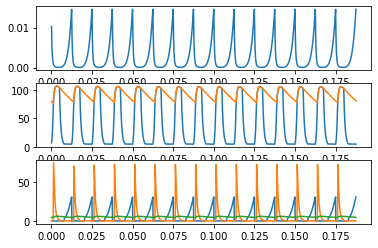

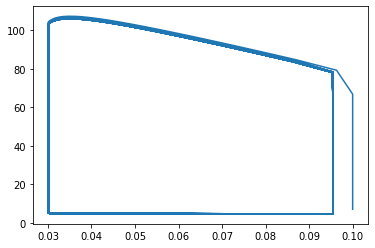

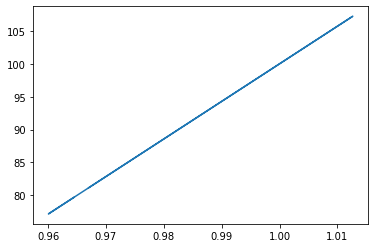

In [4]:
for klok in np.arange(klokmax):
    t = (klok+1)*dt
    PLV_old = copy.deepcopy(PLV)
    Psa_old = copy.deepcopy(Psa)
    CLV_old = copy.deepcopy(CLV)
    CLV = CV_now(t, CLVS, CLVD)
    # find self-consistent valve states and pressures
    PLV, Psa, SMi, SAo = set_SMi_SAo()
    # store in arrays for future plotting:
    t_plot[0, klok] = t
    CLV_plot[0, klok] = CLV
    PLV_plot[0, klok] = PLV
    Psa_plot[0, klok] = Psa
    VLV_plot[0, klok] = CLV * PLV + VLVd
    Vsa_plot[0, klok] = Csa * Psa + Vsad
    QMi_plot[0, klok] = SMi * (PLA - PLV) / RMi
    QAo_plot[0, klok] = SAo * (PLV - Psa) / RAo
    Qs_plot[0, klok] = Psa / Rs
    SMi_plot[0, klok] = SMi
    SAo_plot[0, klok] = SAo
sa_out()